In [1]:
# import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from kerastuner.tuners import RandomSearch


<ipython-input-1-c8d4f5b3dd42>:17: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
# list of companies
companies = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META']

In [3]:
revenue_data = []
for company in companies:
    stock = yf.Ticker(company)
    income_statement = stock.financials
    if not income_statement.empty:
        latest_revenue = income_statement.loc['Total Revenue'].iloc[0]
        revenue_data.append({'symbol': company, 'revenue': latest_revenue})

In [4]:
# Check the structure of revenue_data before sorting
print("Revenue Data: ", revenue_data)

Revenue Data:  [{'symbol': 'AAPL', 'revenue': 383285000000.0}, {'symbol': 'MSFT', 'revenue': 245122000000.0}, {'symbol': 'GOOGL', 'revenue': 307394000000.0}, {'symbol': 'AMZN', 'revenue': 574785000000.0}, {'symbol': 'TSLA', 'revenue': 96773000000.0}, {'symbol': 'META', 'revenue': 134902000000.0}]


In [5]:
# Sort companies by revenue and get the top 3
if revenue_data:
    revenue_df = pd.DataFrame(revenue_data).sort_values(by='revenue', ascending=False).head(3)
    print(revenue_df)
else:
    print("No valid revenue data to sort.")

  symbol       revenue
3   AMZN  5.747850e+11
0   AAPL  3.832850e+11
2  GOOGL  3.073940e+11


In [6]:
# use the top 3 companies for further analysis
top_3 = revenue_df['symbol'].tolist()

In [7]:
# fetch stock data for top 3 companies using yfinance
stock_data = yf.download(top_3, start='2020-01-01', end='2024-01-01')['Adj Close']
stock_data.head()

[*********************100%***********************]  3 of 3 completed


Ticker,AAPL,AMZN,GOOGL
Date,,,
2020-01-02 00:00:00+00:00,72.876122,94.900497,68.264961
2020-01-03 00:00:00+00:00,72.167610,93.748497,67.907845
2020-01-06 00:00:00+00:00,72.742661,95.143997,69.717865
2020-01-07 00:00:00+00:00,72.400528,95.343002,69.583206
2020-01-08 00:00:00+00:00,73.565201,94.598503,70.078476


In [8]:
# summary statistics
stock_data.describe()

Ticker,AAPL,AMZN,GOOGL
count,1006.000000,1006.000000,1006.000000
mean,138.864227,137.216247,107.603801
std,33.576954,27.468805,25.052820
min,54.569736,81.820000,52.576313
25%,121.187897,114.309002,87.811062
50%,143.754517,140.585007,109.617069
75%,164.267056,161.190620,129.928268
max,197.361084,186.570496,149.468399


* AAPL has the highest average price at $138.86.

* AAPL has the highest volatility (std = 33.58).This suggests that AAPL had larger price swings compared to the other two stocks during this period.

* AAPL has the largest range between the minimum and maximum prices, which might indicate periods of significant growth or volatility.

* AAPL had a more significant price increase, as its 75th percentile is much higher compared to the median.

* AMZN appears to have more stable growth, with its price distribution more evenly spread.

* GOOGL had the lowest price range of the three, indicating more steady, less volatile performance.





**Time Series Plot**

In [9]:
# calculate 30-day moving averages
stock_data['AAPL_MA'] = stock_data['AAPL'].rolling(window=30).mean()
stock_data['AMZN_MA'] = stock_data['AMZN'].rolling(window=30).mean()
stock_data['GOOGL_MA'] = stock_data['GOOGL'].rolling(window=30).mean()

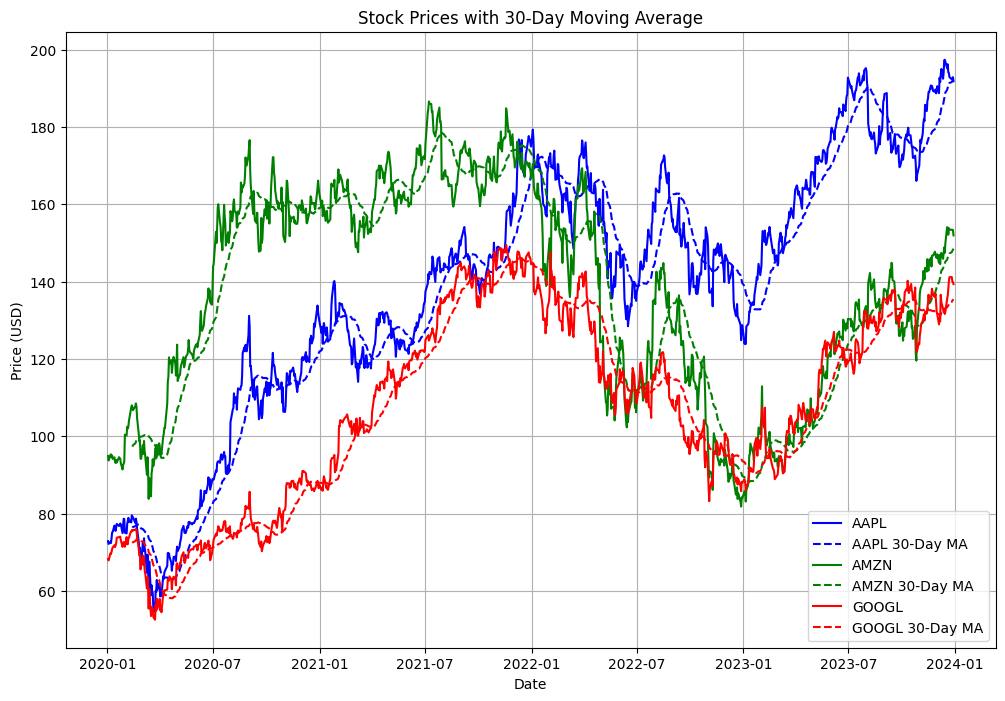

In [10]:
# plotting Time Series for each stock with 30-day Moving Average
plt.figure(figsize=(12, 8))
plt.plot(stock_data.index, stock_data['AAPL'], label='AAPL', color='blue')
plt.plot(stock_data.index, stock_data['AAPL_MA'], label='AAPL 30-Day MA', linestyle='--', color='blue')

plt.plot(stock_data.index, stock_data['AMZN'], label='AMZN', color='green')
plt.plot(stock_data.index, stock_data['AMZN_MA'], label='AMZN 30-Day MA', linestyle='--', color='green')

plt.plot(stock_data.index, stock_data['GOOGL'], label='GOOGL', color='red')
plt.plot(stock_data.index, stock_data['GOOGL_MA'], label='GOOGL 30-Day MA', linestyle='--', color='red')

plt.title('Stock Prices with 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

* AAPL shows significant fluctuations, with upward and downward trends over time.

* AMZN shows similar fluctuations but with less volatility compared to AAPL.

* GOOGL shows a steadier trend with fewer extreme movements.

**Box plot**

<Figure size 1000x600 with 0 Axes>

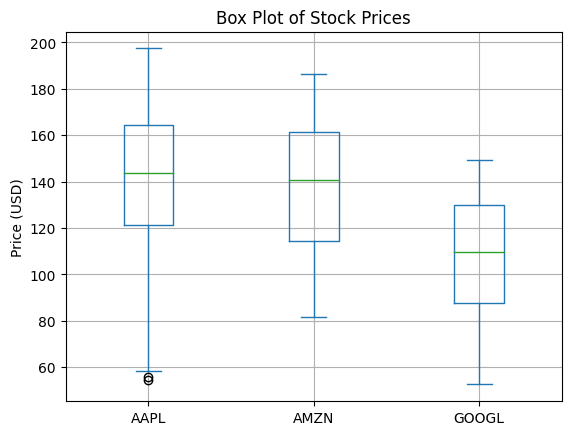

In [11]:
# boxplot of stock prices
plt.figure(figsize=(10, 6))
stock_data[['AAPL', 'AMZN', 'GOOGL']].plot(kind='box')
plt.title('Box Plot of Stock Prices')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

**Histogram Plot**

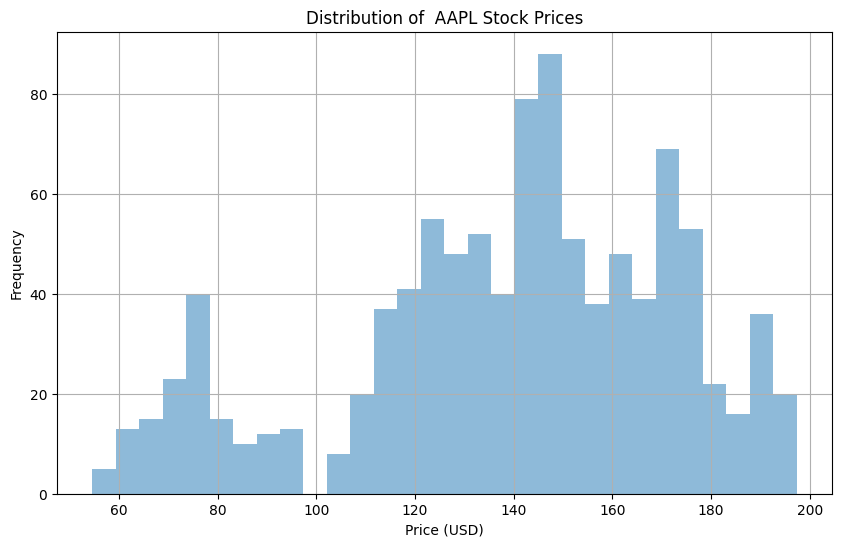

In [12]:
# distribution of  AAPL plot
stock_data['AAPL'].plot(kind='hist', alpha=0.5, bins=30, figsize=(10, 6))
plt.title('Distribution of  AAPL Stock Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

* The distribution is slightly left-skewed, meaning there were more frequent dips in price, but its price tends to hover around a higher mean.
* The distribution has fat tails, suggesting that extreme values (both high and low) occur more frequently than in a normal distribution.

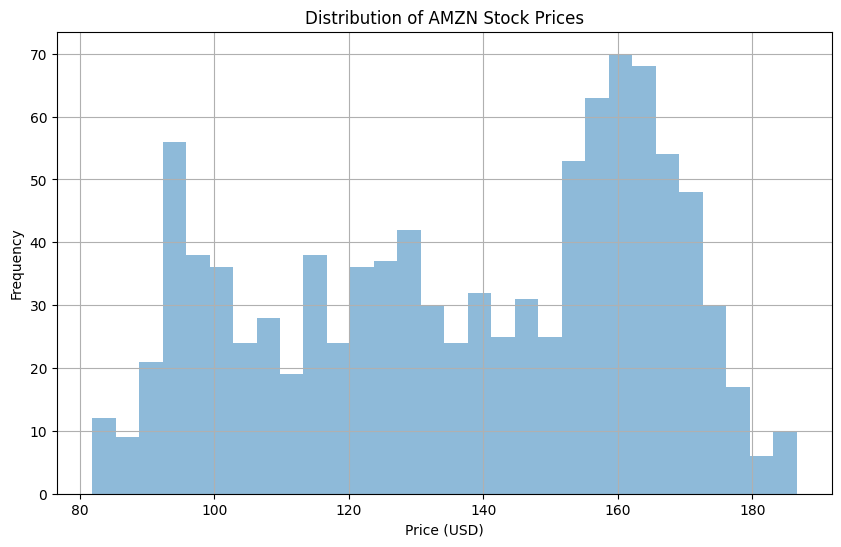

In [13]:
# distribution of AMZN plot
stock_data['AMZN'].plot(kind='hist', alpha=0.5, bins=30, figsize=(10, 6))
plt.title('Distribution of AMZN Stock Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

* The distribution of AMZN is close to normal, with the mean and median stock prices aligning fairly well.
* AMZN shows a symmetric distribution, indicating balanced growth and risk.

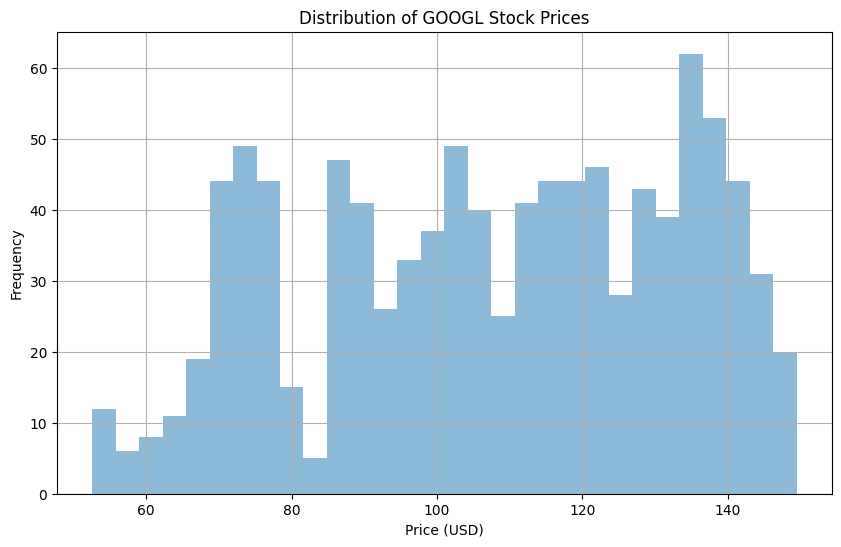

In [14]:
# distribution of GOOGL plot
stock_data['GOOGL'].plot(kind='hist', alpha=0.5, bins=30, figsize=(10, 6))
plt.title('Distribution of GOOGL Stock Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

* GOOGL's distribution is more compact and peaks sharply around its mean, indicating less volatility.
* The right tail is slightly extended, meaning that higher stock prices were more common than lower dips.

**Correlation Heatmap**

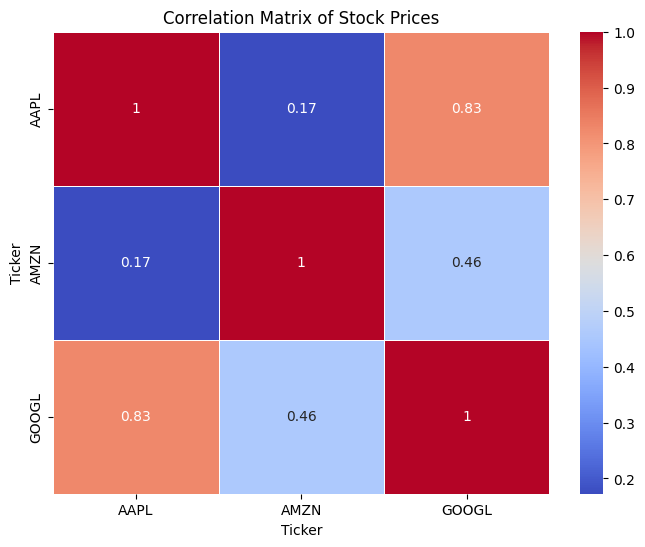

In [15]:
# correlation heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = stock_data[['AAPL', 'AMZN', 'GOOGL']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Stock Prices')
plt.show()

* AAPL and GOOGL have a strong positive correlation of 0.83. This suggests that their stock prices move in the same direction most of the time. When one increases, the other tends to increase as well, and vice versa.

* AMZN and GOOGL have a moderate positive correlation of 0.46. While still positively correlated, their relationship is weaker than that of AAPL and GOOGL. This implies that while these two stocks may move in the same direction, it is not as consistent.

* AAPL and AMZN show a weak positive correlation of 0.17 meaning that their stock prices do not move together frequently. When one stock rises or falls, the other is less likely to follow the same pattern.

**Decompose the Time Series**

Seasonal-Trend Decomposition: Decomposing the time series into trend, seasonality, and residual (noise) components to identify patterns that might affect future prices.

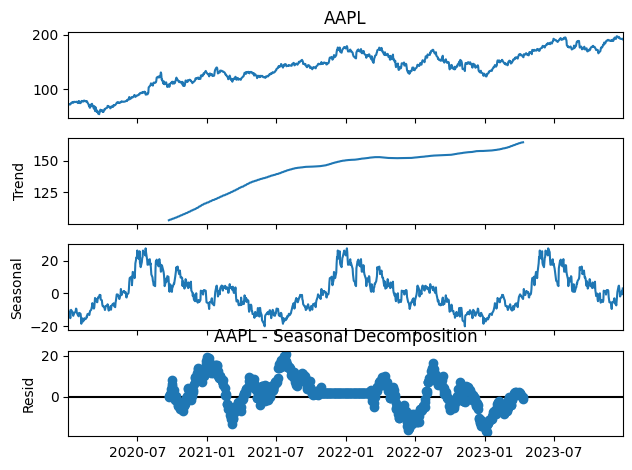

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

# decompose the time series for each stock (Additive model)
result_aapl = seasonal_decompose(stock_data['AAPL'], model='additive', period=365)
result_amzn = seasonal_decompose(stock_data['AMZN'], model='additive', period=365)
result_googl = seasonal_decompose(stock_data['GOOGL'], model='additive', period=365)

# plot the decomposition for AAPL
result_aapl.plot()
plt.title('AAPL - Seasonal Decomposition')
plt.show()


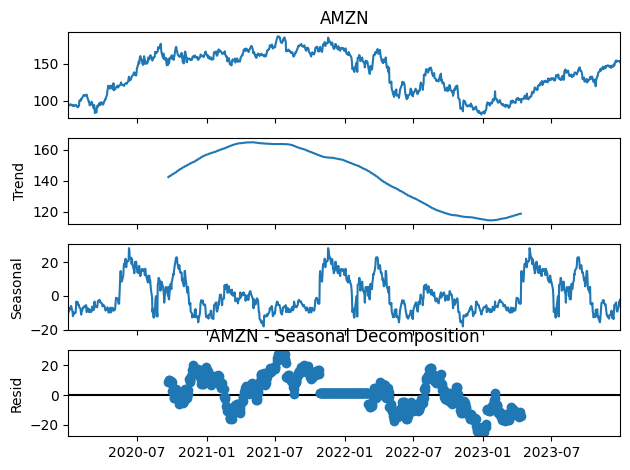

In [17]:
# plot the decomposition for AMZN
result_amzn.plot()
plt.title('AMZN - Seasonal Decomposition')
plt.show()

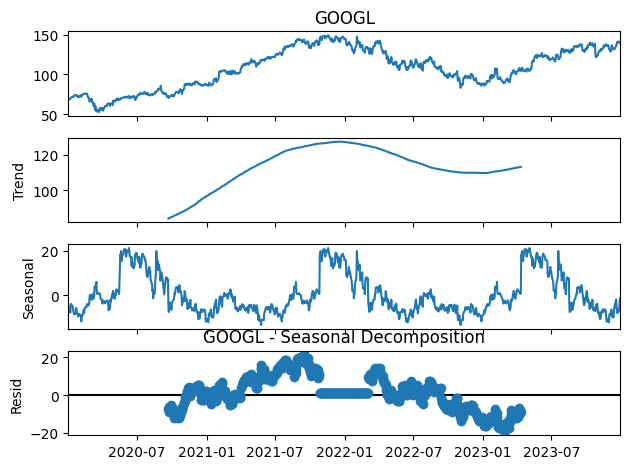

In [18]:
# plot the decomposition for GOOGL
result_googl.plot()
plt.title('GOOGL - Seasonal Decomposition')
plt.show()

* Apple (AAPL) stands out as the most stable and resilient stock, with consistent upward growth and less impact from external factors. It also has predictable seasonal patterns, which are likely linked to product launches and holiday demand.
* Amazon (AMZN) shows the most pronounced seasonal variability, reflecting its e-commerce focus, but also has the most volatile trend and residuals, suggesting it is more sensitive to market fluctuations and external factors.
* Google (GOOGL) shares a similar overall pattern to AMZN, with a peak in 2021 and a downturn in 2022, followed by recovery in 2023. Google also has significant seasonal patterns but shows greater residual volatility, likely reflecting the company’s dependence on digital advertising and tech industry cycles.
* Apple's stock is generally seen as a safer, long-term investment, while Amazon and Google, despite being strong companies, may be viewed as more volatile in the short term but offer opportunities for strategic investments based on seasonal patterns and recovery trends.

**Lag Features**

Lag features create columns that shift stock prices by a certain number of days to capture dependencies in the stock data. This helps the model learn from previous values.

In [19]:
# create lagged features (1-day lag and 7-day lag as an example)
stock_data['AAPL_Lag1'] = stock_data['AAPL'].shift(1)
stock_data['AAPL_Lag7'] = stock_data['AAPL'].shift(7)

stock_data['AMZN_Lag1'] = stock_data['AMZN'].shift(1)
stock_data['AMZN_Lag7'] = stock_data['AMZN'].shift(7)

stock_data['GOOGL_Lag1'] = stock_data['GOOGL'].shift(1)
stock_data['GOOGL_Lag7'] = stock_data['GOOGL'].shift(7)

# Drop rows with NaN values caused by the lag shift
stock_data.dropna(inplace=True)


In [20]:
print(stock_data.info())
stock_data.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 977 entries, 2020-02-13 00:00:00+00:00 to 2023-12-29 00:00:00+00:00
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AAPL        977 non-null    float64
 1   AMZN        977 non-null    float64
 2   GOOGL       977 non-null    float64
 3   AAPL_MA     977 non-null    float64
 4   AMZN_MA     977 non-null    float64
 5   GOOGL_MA    977 non-null    float64
 6   AAPL_Lag1   977 non-null    float64
 7   AAPL_Lag7   977 non-null    float64
 8   AMZN_Lag1   977 non-null    float64
 9   AMZN_Lag7   977 non-null    float64
 10  GOOGL_Lag1  977 non-null    float64
 11  GOOGL_Lag7  977 non-null    float64
dtypes: float64(12)
memory usage: 99.2 KB
None


Ticker,AAPL,AMZN,GOOGL,AAPL_MA,AMZN_MA,GOOGL_MA,AAPL_Lag1,AAPL_Lag7,AMZN_Lag1,AMZN_Lag7,GOOGL_Lag1,GOOGL_Lag7
Date,,,,,,,,,,,,
2020-02-13 00:00:00+00:00,79.012657,107.493500,75.482597,76.361987,97.311366,72.386144,79.579338,77.364891,108.000000,102.483498,75.743950,72.091988
2020-02-14 00:00:00+00:00,79.032112,106.743500,75.748932,76.567186,97.706133,72.635610,79.012657,77.995758,107.493500,101.993500,75.482597,72.123909
2020-02-18 00:00:00+00:00,77.584991,107.783501,75.784348,76.747766,98.173966,72.898160,79.032112,78.908081,106.743500,102.511497,75.748932,73.616211
2020-02-19 00:00:00+00:00,78.708641,108.511002,76.055176,76.946632,98.619533,73.109403,77.584991,77.835510,107.783501,103.963997,75.784348,73.772827
2020-02-20 00:00:00+00:00,77.901169,107.654999,75.662148,77.129987,99.029933,73.312035,78.708641,78.205185,108.511002,106.695503,76.055176,75.246681


**Stationarity**

Time series forecasting models like ARIMA require the data to be stationary (i.e., the statistical properties like mean and variance are constant over time). You can use the Augmented Dickey-Fuller (ADF) test to check this.

In [21]:
from statsmodels.tsa.stattools import adfuller

# ADF test for AAPL
adf_result = adfuller(stock_data['AAPL'])
print(f'ADF Statistic for AAPL: {adf_result[0]}')
print(f'p-value for AAPL: {adf_result[1]}')

# If p-value is less than 0.05, the data is stationary


ADF Statistic for AAPL: -1.5035359077224348
p-value for AAPL: 0.5317614563593129


- The p-value is greater than 0.05 which means the data is non-stationary, we can make it stationary using differencing:

In [22]:
# differencing
stock_data['AAPL_Diff'] = stock_data['AAPL'].diff().dropna()

**ACF and PACF plots**

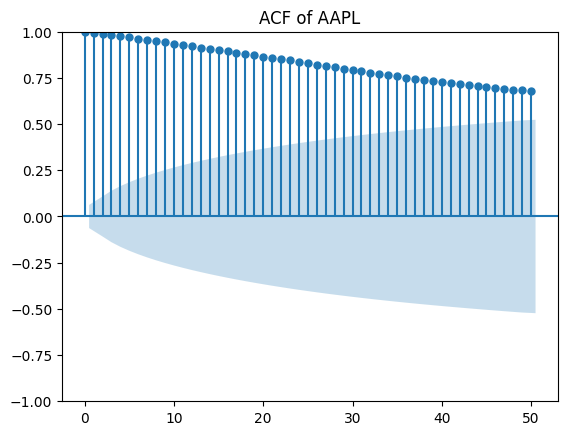

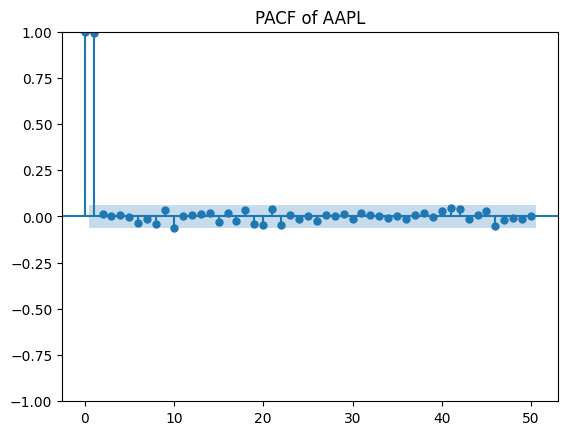

In [23]:
# acf plot for AAPL
plot_acf(stock_data['AAPL'], lags=50)
plt.title('ACF of AAPL')
plt.show()

# pacf plot for AAPL
plot_pacf(stock_data['AAPL'], lags=50)
plt.title('PACF of AAPL')
plt.show()


**APPLE**

**Model Building**

**train-test split**

In [24]:
# data for AAPL stock
aapl_data = stock_data['AAPL']

# split
train, test = train_test_split(aapl_data, train_size=0.8, shuffle=False)

print(f"Training set: {len(train)} samples")
print(f"Test set: {len(test)} samples")

Training set: 781 samples
Test set: 196 samples


**Model 1: ARIMA (AutoRegressive Integrated Moving Average)**

In [25]:
# build ARIMA model
aapl_arima_model = ARIMA(train, order=(5,1,2))  # (p,d,q) order for ARIMA
aapl_arima_model_fit = aapl_arima_model.fit()

# forecast for the test set
aapl_arima_forecast = aapl_arima_model_fit.forecast(steps=len(test))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

In [26]:
# evaluate ARIMA model
aapl_mae_arima = mean_absolute_error(test, aapl_arima_forecast)
aapl_rmse_arima = np.sqrt(mean_squared_error(test, aapl_arima_forecast))

print(f' AAPL ARIMA MAE: {aapl_mae_arima}')
print(f'AAPL ARIMA RMSE: {aapl_rmse_arima}')

 AAPL ARIMA MAE: 20.979095506374488
AAPL ARIMA RMSE: 23.36504735125138


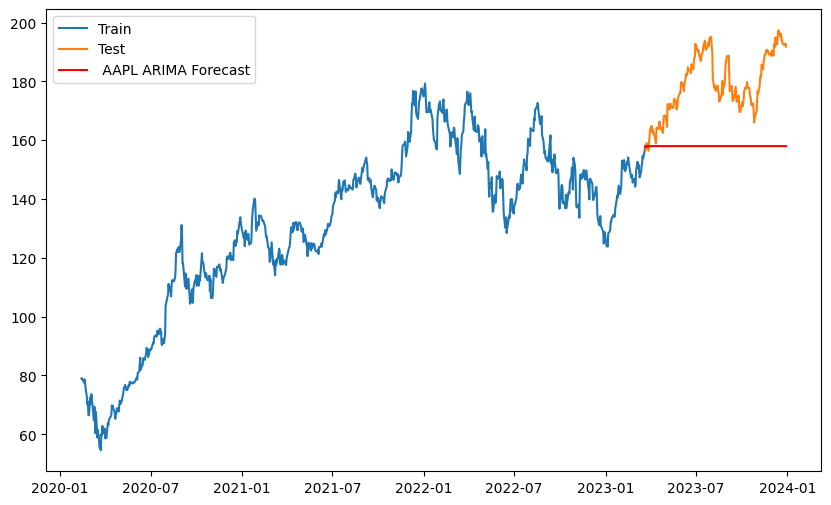

In [27]:
# plot the forecast against the actual data
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, aapl_arima_forecast, label=' AAPL ARIMA Forecast', color='red')
plt.legend()
plt.show()

**Model 2: SARIMA (Seasonal Arima)**

In [28]:
# fit SARIMA model
aapl_sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()

# forecast on the test data
aapl_sarima_forecast = aapl_sarima_model.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [29]:
# evaluate SARIMA model
aapl_sarima_mae = mean_absolute_error(test, aapl_sarima_forecast)
aapl_sarima_rmse = np.sqrt(mean_squared_error(test, aapl_sarima_forecast))

print(f'SARIMA MAE: {aapl_sarima_mae}')
print(f'SARIMA RMSE: {aapl_sarima_rmse}')

SARIMA MAE: 11.844509503766472
SARIMA RMSE: 14.231442730924575


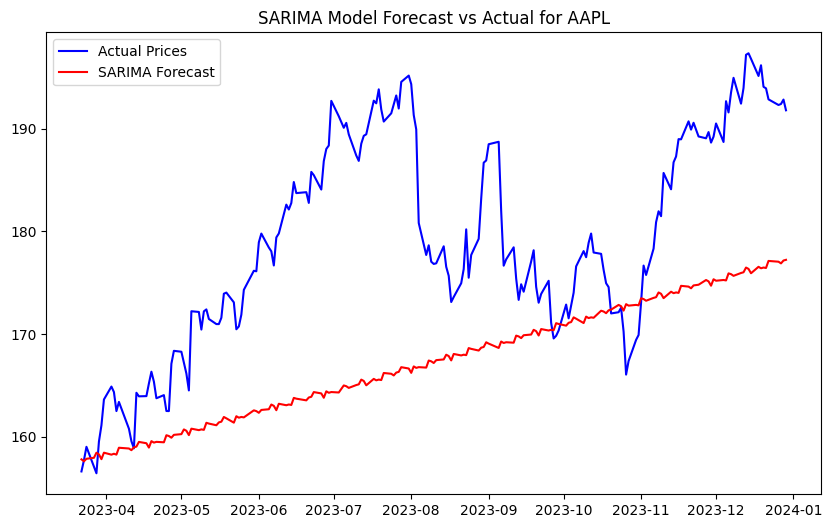

In [30]:
# plot the forecast vs actual
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual Prices', color='blue')
plt.plot(test.index, aapl_sarima_forecast, label='SARIMA Forecast', color='red')
plt.title('SARIMA Model Forecast vs Actual for AAPL')
plt.legend()
plt.show()

**Model 3:LSTM**

In [31]:
# scaling the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

# prepare data
def create_lstm_dataset(aapl_data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(aapl_data)):
        X.append(aapl_data[i-time_steps:i, 0])
        y.append(aapl_data[i, 0])
    return np.array(X), np.array(y)

# creating LSTM input/output
time_steps = 60
X_train, y_train = create_lstm_dataset(train_scaled, time_steps)
X_test, y_test = create_lstm_dataset(test_scaled, time_steps)

# reshaping the data to fit LSTM (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [32]:
# build the LSTM model
aapl_lstm_model = Sequential()
aapl_lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
aapl_lstm_model.add(LSTM(units=50))
aapl_lstm_model.add(Dense(1))  # Output layer for predicting the stock price

aapl_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# fit the model
aapl_lstm_model.fit(X_train, y_train, epochs=20, batch_size=32)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.2281
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0095
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0042
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0030
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0029
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0024
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0024
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0022
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0024
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0021
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0021
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0021
Epoch 13/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0024
Epoch 14/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0020
Epoch 15/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0019
Epoch 16/20
23/

In [33]:
# predicting the test set
aapl_lstm_pred_scaled = aapl_lstm_model.predict(X_test)

# inverse scaling to get the original prices back
aapl_lstm_pred = scaler.inverse_transform(aapl_lstm_pred_scaled)

# evaluate the LSTM model
aapl_lstm_mae = mean_absolute_error(test[time_steps:], aapl_lstm_pred)
aapl_lstm_rmse = np.sqrt(mean_squared_error(test[time_steps:], aapl_lstm_pred))

print(f' AAPL LSTM MAE: {aapl_lstm_mae}')
print(f'AAPL LSTM RMSE: {aapl_lstm_rmse}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
 AAPL LSTM MAE: 6.3942491867963005
AAPL LSTM RMSE: 7.370875790218505


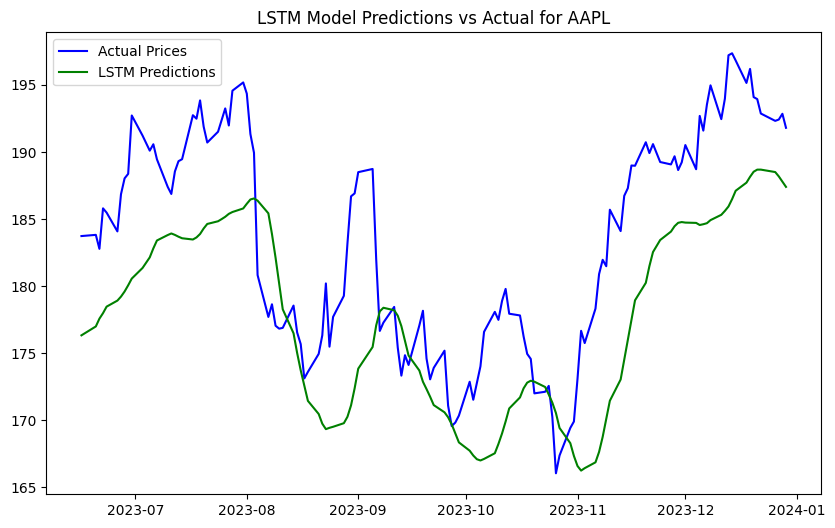

In [34]:
# plot the LSTM predictions vs actual prices
plt.figure(figsize=(10, 6))
plt.plot(test.index[time_steps:], test[time_steps:], label='Actual Prices', color='blue')
plt.plot(test.index[time_steps:], aapl_lstm_pred, label='LSTM Predictions', color='green')
plt.title('LSTM Model Predictions vs Actual for AAPL')
plt.legend()
plt.show()

**AMAZON**

In [35]:
# data for AMZN stock
amzn_data = stock_data['AMZN']

# split
train, test = train_test_split(amzn_data, train_size=0.8, shuffle=False)

print(f"Training set: {len(train)} samples")
print(f"Test set: {len(test)} samples")

Training set: 781 samples
Test set: 196 samples


**Model 1: ARIMA**

In [36]:
# build ARIMA model
amzn_arima_model = ARIMA(train, order=(5,1,2))  # (p,d,q) order for ARIMA
amzn_arima_model_fit = amzn_arima_model.fit()

# forecast for the test set
amzn_arima_forecast = amzn_arima_model_fit.forecast(steps=len(test))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/di

In [37]:
# evaluate ARIMA model
amzn_mae_arima = mean_absolute_error(test, amzn_arima_forecast)
amzn_rmse_arima = np.sqrt(mean_squared_error(test, amzn_arima_forecast))

print(f' AMZN ARIMA MAE: {amzn_mae_arima}')
print(f'AMZN ARIMA RMSE: {amzn_rmse_arima}')

 AMZN ARIMA MAE: 27.759026435038415
AMZN ARIMA RMSE: 31.37144935129493


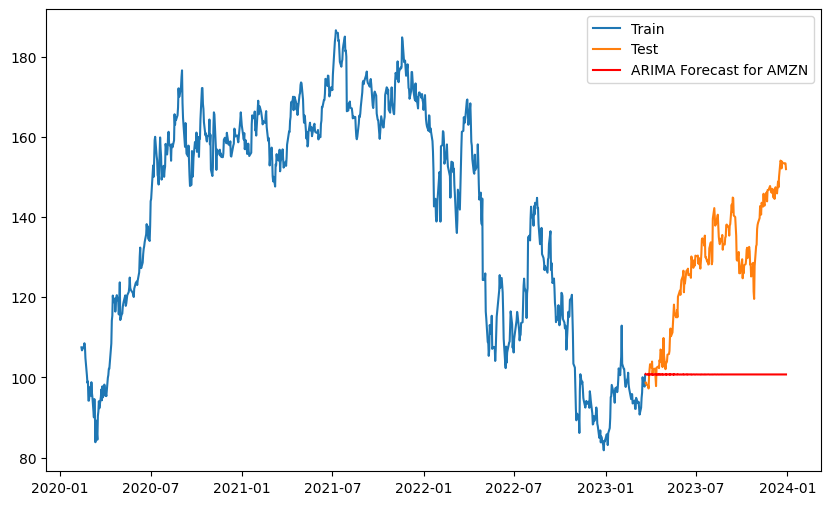

In [38]:
# plot the forecast against the actual data
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, amzn_arima_forecast, label='ARIMA Forecast for AMZN', color='red')
plt.legend()
plt.show()

**Model 2: SARIMA**

In [39]:
# fit SARIMA model
amzn_sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()

# forecast on the test data
amzn_sarima_forecast = amzn_sarima_model.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [40]:
# evaluate SARIMA model
amzn_sarima_mae = mean_absolute_error(test, amzn_sarima_forecast)
amzn_sarima_rmse = np.sqrt(mean_squared_error(test, amzn_sarima_forecast))

print(f' AMZN SARIMA MAE: {amzn_sarima_mae}')
print(f'AMZN SARIMA RMSE: {amzn_sarima_rmse}')

 AMZN SARIMA MAE: 28.775370490389253
AMZN SARIMA RMSE: 32.47745002814063


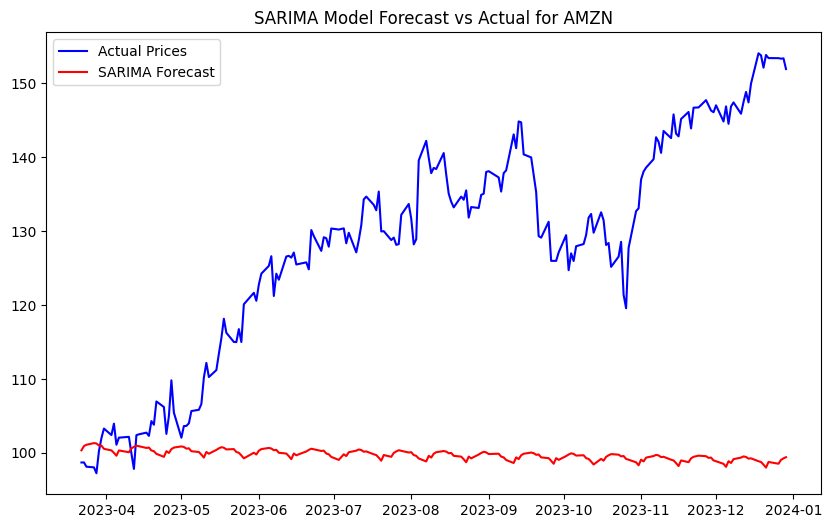

In [41]:
# plot the forecast vs actual
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual Prices', color='blue')
plt.plot(test.index, amzn_sarima_forecast, label='SARIMA Forecast', color='red')
plt.title('SARIMA Model Forecast vs Actual for AMZN')
plt.legend()
plt.show()

**Model 3: LTSM**

In [42]:
# scaling the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

# prepare data
def create_lstm_dataset(amzn_data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(amzn_data)):
        X.append(amzn_data[i-time_steps:i, 0])
        y.append(amzn_data[i, 0])
    return np.array(X), np.array(y)

# creating LSTM input/output
time_steps = 60
X_train, y_train = create_lstm_dataset(train_scaled, time_steps)
X_test, y_test = create_lstm_dataset(test_scaled, time_steps)

# reshaping the data to fit LSTM (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [43]:
# build the LSTM model
amzn_lstm_model = Sequential()
amzn_lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
amzn_lstm_model.add(LSTM(units=50))
amzn_lstm_model.add(Dense(1))  # Output layer for predicting the stock price

amzn_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# fit the model
amzn_lstm_model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.1910
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0109
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0068
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0047
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0048
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0044
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0042
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0042
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0041
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0038
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0039
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0034
Epoch 13/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0038
Epoch 14/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0033
Epoch 15/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0032
Epoch 16/20
23/

In [44]:
# predicting the test set
amzn_lstm_pred_scaled = amzn_lstm_model.predict(X_test)

# inverse scaling to get the original prices back
amzn_lstm_pred = scaler.inverse_transform(amzn_lstm_pred_scaled)

# evaluate the LSTM model
amzn_lstm_mae = mean_absolute_error(test[time_steps:], amzn_lstm_pred)
amzn_lstm_rmse = np.sqrt(mean_squared_error(test[time_steps:], amzn_lstm_pred))

print(f' AMZN LSTM MAE: {amzn_lstm_mae}')
print(f'AMZN LSTM RMSE: {amzn_lstm_rmse}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
 AMZN LSTM MAE: 3.118585474350873
AMZN LSTM RMSE: 4.0568741600383795


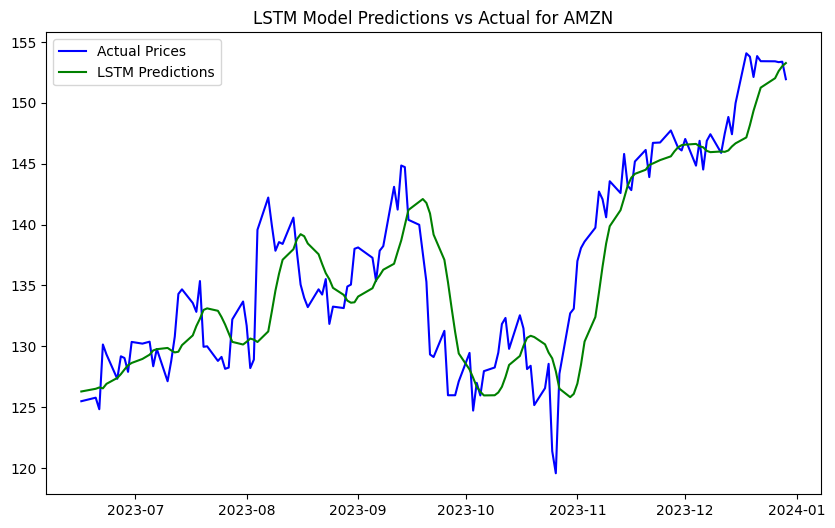

In [45]:
# plot the LSTM predictions vs actual prices
plt.figure(figsize=(10, 6))
plt.plot(test.index[time_steps:], test[time_steps:], label='Actual Prices', color='blue')
plt.plot(test.index[time_steps:], amzn_lstm_pred, label='LSTM Predictions', color='green')
plt.title('LSTM Model Predictions vs Actual for AMZN')
plt.legend()
plt.show()

**GOOGL**

In [46]:
# data for GOOGL stock
googl_data = stock_data['GOOGL']

# split
train, test = train_test_split(googl_data, train_size=0.8, shuffle=False)

print(f"Training set: {len(train)} samples")
print(f"Test set: {len(test)} samples")

Training set: 781 samples
Test set: 196 samples


In [47]:
# build ARIMA model
googl_arima_model = ARIMA(train, order=(5,1,2))  # (p,d,q) order for ARIMA
googl_arima_model_fit = googl_arima_model.fit()

# forecast for the test set
googl_arima_forecast = googl_arima_model_fit.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

In [48]:
# evaluate ARIMA model
googl_mae_arima = mean_absolute_error(test, googl_arima_forecast)
googl_rmse_arima = np.sqrt(mean_squared_error(test, googl_arima_forecast))

print(f'GOOGL ARIMA MAE: {googl_mae_arima}')
print(f'GOOGL ARIMA RMSE: {googl_rmse_arima}')

GOOGL ARIMA MAE: 22.016238754928423
GOOGL ARIMA RMSE: 24.59952678234647


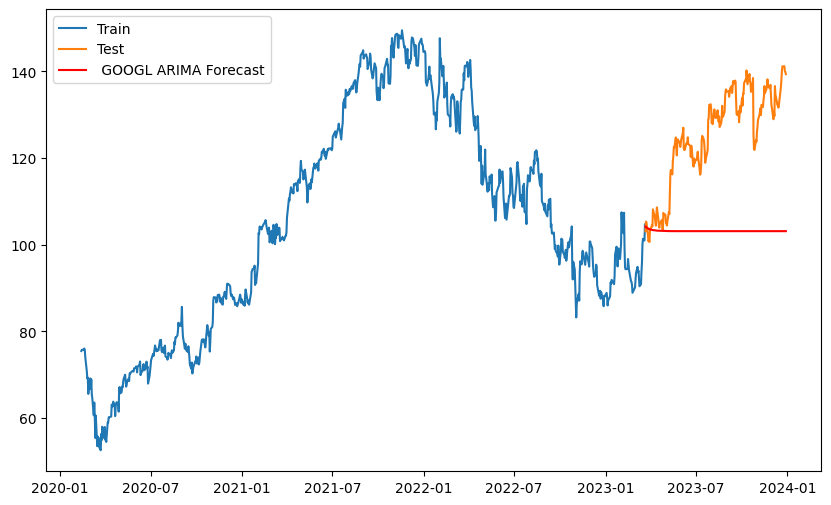

In [49]:
# plot the forecast against the actual data
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, googl_arima_forecast, label=' GOOGL ARIMA Forecast', color='red')
plt.legend()
plt.show()

**Model 2: SARIMA**

In [50]:
# fit SARIMA model
googl_sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()

# forecast on the test data
googl_sarima_forecast = googl_sarima_model.forecast(steps=len(test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [51]:
# evaluate SARIMA model
googl_sarima_mae = mean_absolute_error(test, googl_sarima_forecast)
googl_sarima_rmse = np.sqrt(mean_squared_error(test, googl_sarima_forecast))

print(f' AMZN SARIMA MAE: {googl_sarima_mae}')
print(f'AMZN SARIMA RMSE: {googl_sarima_rmse}')

 AMZN SARIMA MAE: 17.868931224958473
AMZN SARIMA RMSE: 20.013787587470933


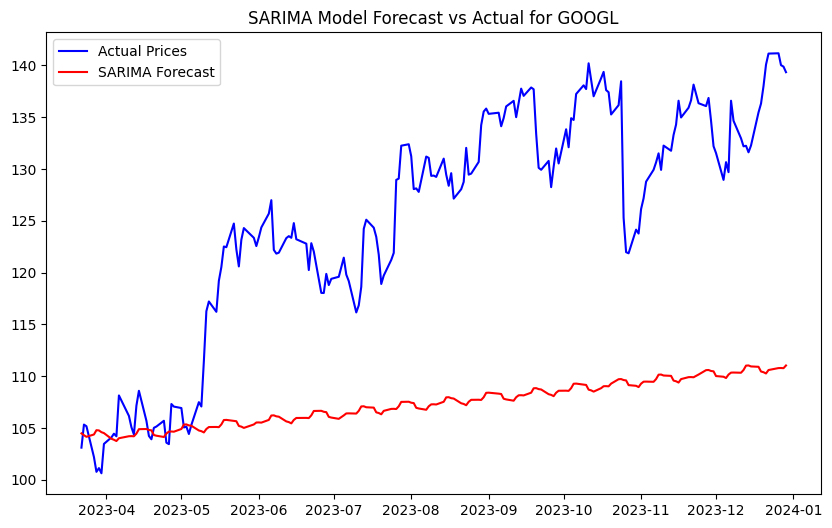

In [52]:
# plot the forecast vs actual
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual Prices', color='blue')
plt.plot(test.index, googl_sarima_forecast, label='SARIMA Forecast', color='red')
plt.title('SARIMA Model Forecast vs Actual for GOOGL')
plt.legend()
plt.show()

**Model 3: LSTM**

In [53]:
# scaling the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

# prepare data
def create_lstm_dataset(googl_data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(googl_data)):
        X.append(googl_data[i-time_steps:i, 0])
        y.append(googl_data[i, 0])
    return np.array(X), np.array(y)

# creating LSTM input/output
time_steps = 60
X_train, y_train = create_lstm_dataset(train_scaled, time_steps)
X_test, y_test = create_lstm_dataset(test_scaled, time_steps)

# reshaping the data to fit LSTM (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [54]:
# build the LSTM model
googl_lstm_model = Sequential()
googl_lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
googl_lstm_model.add(LSTM(units=50))
googl_lstm_model.add(Dense(1))  # Output layer for predicting the stock price

googl_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# fit the model
googl_lstm_model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.1617
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0086
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0033
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0023
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0021
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0022
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0021
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0021
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0020
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0020
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0020
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0020
Epoch 13/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0020
Epoch 14/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0018
Epoch 15/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0020
Epoch 16/20
23/

In [55]:
# predicting the test set
googl_lstm_pred_scaled = googl_lstm_model.predict(X_test)

# inverse scaling to get the original prices back
googl_lstm_pred = scaler.inverse_transform(googl_lstm_pred_scaled)

# evaluate the LSTM model
googl_lstm_mae = mean_absolute_error(test[time_steps:], googl_lstm_pred)
googl_lstm_rmse = np.sqrt(mean_squared_error(test[time_steps:], googl_lstm_pred))

print(f' GOOGL LSTM MAE: {googl_lstm_mae}')
print(f'GOOGL LSTM RMSE: {googl_lstm_rmse}')

4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
 GOOGL LSTM MAE: 3.270424450145048
GOOGL LSTM RMSE: 4.265794960682572


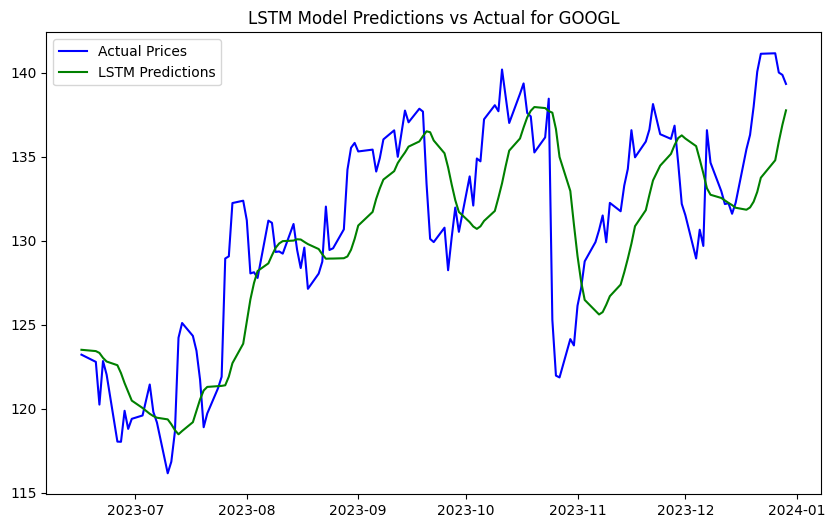

In [56]:
# plot the LSTM predictions vs actual prices
plt.figure(figsize=(10, 6))
plt.plot(test.index[time_steps:], test[time_steps:], label='Actual Prices', color='blue')
plt.plot(test.index[time_steps:], googl_lstm_pred, label='LSTM Predictions', color='green')
plt.title('LSTM Model Predictions vs Actual for GOOGL')
plt.legend()
plt.show()